## 뉴욕시의 Taxi 데이터 활용한 예측 모델
---
- 데이터셋 : 캐글의 NYC_taxi 데이터
- 예측 (1) : 거리에 따른 요금 예측 : 회귀식 사용

* 조건 : 뉴욕시 내

---
## [1] 데이터 불러오기

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 데이터 로딩
# nrows = 로딩 데이터 수
# pickup_datetime 컬럼의 타입을 시계열 타입으로 변경
df = pd.read_csv('train.csv', nrows = 5000, parse_dates= ['pickup_datetime'])

In [27]:
# 라이브러리 import
import matplotlib.pyplot as plt
import	platform

# 시스템별 한글 폰트 설정
if	platform.system()	==	'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system()	==	'Darwin':	#	MacOS
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='AppleGothic')

In [28]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


### [2] 결측치 및 이상치 체크

In [29]:
# 결측치 확인
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [30]:
# 이상치 확인
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,11.296238,-72.426826,39.867237,-72.426130,39.875767,1.631000
std,9.710106,10.722381,6.351342,10.722293,6.326084,1.257122
min,-2.900000,-74.438233,-73.991840,-74.429332,-73.979010,0.000000
25%,6.000000,-73.992449,40.734045,-73.991349,40.734379,1.000000
50%,8.500000,-73.982069,40.752128,-73.980196,40.753512,1.000000
75%,12.500000,-73.967040,40.766890,-73.963589,40.767636,2.000000
max,180.000000,40.751582,41.366138,40.758867,41.032598,6.000000


* 요금의 min 값이 - 값임
* 고객이 min 값이 0임

### 특성 추가 => 거리 Feature
- 공식 $(x2 - x1)^2 + (y2 - y1)^2$  

In [31]:
df = df[(df["pickup_longitude"] <= -71.47) & (df["pickup_longitude"] >= -79.45)]
df = df[(df["pickup_latitude"] >= 40.29) & (df["pickup_latitude"] <= 45)]
df = df[(df["dropoff_longitude"] <= -71.47) & (df["dropoff_longitude"] >= -79.45)]
df = df[(df["dropoff_latitude"] >= 40.29) & (df["dropoff_latitude"] <= 45)]

In [32]:
df = df[(df["fare_amount"] <= 150) & (df["fare_amount"] > 0)]

In [33]:
df['distance'] = (((df['pickup_longitude'] - df['dropoff_longitude']) ** 2 + (df['pickup_latitude'] - df['dropoff_latitude']) ** 2) ** 0.5) 

In [34]:
df = df[(df["distance"] <= 90) & (df["distance"] > 0)]

In [35]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.009436
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,0.079696
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.013674
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,0.025340
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,0.019470


In [36]:
# 정규화 
distance = df['distance']
dis_max = max(distance)
dis_min =  min(distance)

fare = df['fare_amount']
fare_max = max(fare)
fare_min = min(fare)

In [37]:
distance = (distance - dis_min) / (dis_max - dis_min)
fare = (fare - fare_min) / (fare_max - fare_min)

In [38]:
# 표준화
distance = df['distance']
dis_mean = distance.mean()
dis_std =  distance.std()

fare = df['fare_amount']
fare_mean = fare.mean()
fare_std = fare.std()

In [39]:
distance = (distance - dis_mean) / dis_std
fare = (fare - fare_mean) / fare_std

예측 (1) : 거리에 따른 요금 예측 : 회귀식 사용

In [40]:
# 훈련 세트와 테스트 세트로 나눔
from sklearn.model_selection import train_test_split

train_distance, test_distance, train_fare, test_fare = train_test_split(
    distance, fare, random_state=42)

In [41]:
# array 로 변경
train_distance = np.array(train_distance)
test_distance = np.array(test_distance)

# 2차원 배열로 변경
train_distance = train_distance.reshape(-1, 1)
test_distance = test_distance.reshape(-1, 1)

# 이자율을 제곱한 데이터를 훈련 세트에 추가
train_poly = np.column_stack((train_distance ** 2, train_distance))
test_poly = np.column_stack((test_distance ** 2, test_distance))

In [42]:
# 데이터 준비
from sklearn.linear_model import LinearRegression

# 모델 생성
lr = LinearRegression()
# 모델 훈련
lr.fit(train_poly, train_fare)

LinearRegression()

In [43]:
# 새로운 각 항의 계수와 절편 구하기
print(lr.coef_, lr.intercept_)

[-0.05563017  1.19236969] 0.05709733766137333


In [44]:
lr.coef_[0], lr.coef_[1]

(-0.05563016777002395, 1.1923696864920081)

In [45]:
# 선을 그리는데 필요한 값 저장
point = np.arange(1, 15, 0.1)
point

array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
        4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
        5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
        6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
        7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
        8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
        9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8,
       10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9,
       12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. ,
       13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1,
       14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9])

In [46]:
lr.predict([[64,8]])

array([6.03572409])

c:\Users\LJH\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


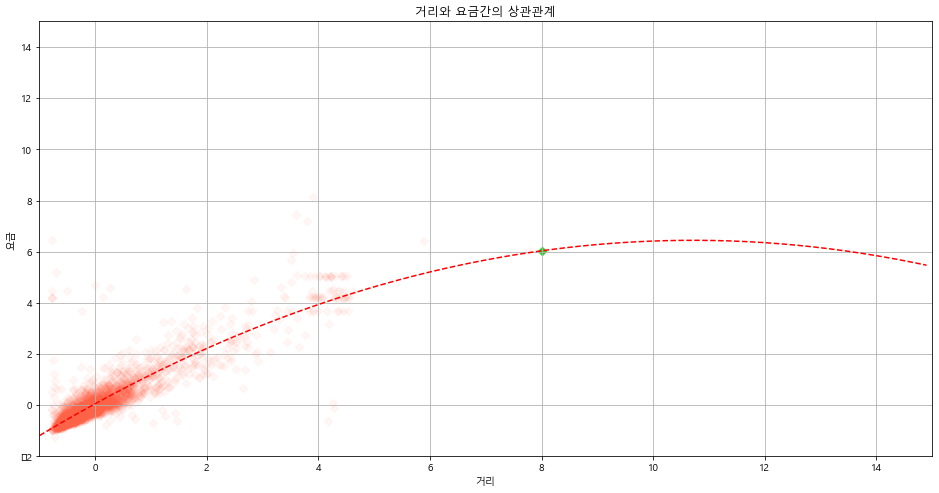

In [47]:
# 다항 회귀식을 이용한 그래프 그리기

# 직선을 위한 수 배열
point = np.arange(-3, 15, 0.1)

plt.figure(figsize = (16, 8))
plt.scatter(train_distance, train_fare, color = 'tomato', marker = 'D', alpha= 0.05)
plt.plot(point, lr.coef_[0] * point ** 2 + lr.coef_[1] * point + lr.intercept_, color ='red', linestyle = '--')
plt.scatter(8, lr.predict([[64,8]]), color = 'limegreen', marker = 'D')
plt.title('거리와 요금간의 상관관계')
plt.xlabel('거리')
plt.ylabel('요금')
plt.xlim(-1, 15)
plt.ylim(-2, 15)
plt.grid(True)
plt.show()

In [48]:
print('훈련 점수 :', lr.score(train_poly, train_fare))
print('테스트 점수 :', lr.score(test_poly, test_fare))

훈련 점수 : 0.7858633599859296
테스트 점수 : 0.7708243700194267


훈련 점수가 테스트 점수보다 낮으니 과소 적합 상태

## (2) 당뇨 발생 여부
- Dataset : diabetes.csv
- 조건) 당뇨병 발병 확률이 XX%입니다.

In [56]:
diabets = pd.read_csv('diabetes.csv')

In [57]:
diabets.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [64]:
input = diabets.iloc[:,:-1]
target = diabets.iloc[:,-1]

In [66]:
train_input, test_input, train_target, test_target = train_test_split(
    input, target, test_size = 0.2, random_state=42
)

In [67]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(train_input, train_target)

c:\Users\LJH\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [71]:
print('훈련 점수 :', model.score(train_input, train_target))
print('테스트 점수 :', model.score(test_input, test_target))

훈련 점수 : 0.7719869706840391
테스트 점수 : 0.7467532467532467


과대 적합 상태

model.score(test_data, test_target)

In [72]:
diabets.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


독립 변수 간 에서 Age와 Pregnancies가 가장 높고, SkinThickness와 Insulin도 상관 계수가 높은편

In [78]:
# Pregnancies와 SkinThickness를 제거해보고 다시 계산
input_02 = diabets.iloc[:, [1,2,4,5,6,7]]

In [79]:
train_input_02, test_input_02, train_target, test_target = train_test_split(
    input_02, target, test_size = 0.2, random_state=42
)

In [80]:
model_02 = LogisticRegression()
model_02.fit(train_input_02, train_target)

LogisticRegression()

In [81]:
print('훈련 점수 :', model_02.score(train_input_02, train_target))
print('테스트 점수 :', model_02.score(test_input, test_target))

훈련 점수 : 0.7768729641693811
테스트 점수 : 0.7597402597402597


model_2 여전히 과대 적합이지만 더 적은 변수를 가지고  
model 보다 더 높은 점수를 보이고 있다.

In [82]:
diabets.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [85]:
model.predict_proba([[3.8, 120.8, 69.1, 20.5, 79.8, 31.9, 0.47, 33.2]])

c:\Users\LJH\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[0.70558664, 0.29441336]])

In [86]:
model_02.predict_proba([[120.8, 69.1, 79.8, 31.9, 0.47, 33.2]])

c:\Users\LJH\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[0.70565786, 0.29434214]])

독립변수가 2개가 줄었슴에도 두 모델 모두 거의 동일하게 분석